## Imports

In [75]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

## Loading data

In [76]:
train_data = pd.read_csv("./datasets/train.csv")
test_data = pd.read_csv("./datasets/test.csv")

## Analyzing data

In [77]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [78]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [79]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [80]:
train_data.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Johansson, Mr. Erik",male,347082,B96 B98,S
freq,1,577,7,4,644


In [81]:
t = train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().sort_values(by='Survived', ascending=False)
t['PclassSize'] = train_data['Pclass'].value_counts()
t

,Survived,PclassSize
Pclass,,
1,0.629630,216
2,0.472826,184
3,0.242363,491


In [82]:
t = train_data[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean().sort_values(by='Survived', ascending=False)
t['SexSize'] = train_data['Sex'].value_counts()
t

,Survived,SexSize
Sex,,
female,0.742038,314
male,0.188908,577


### What do we know?
- 891 samples
- Cabin, Age, Embarked are missing
- 38% of all samples survived
- more than 50% samples were on 3-rd class and 24% of them survived
- 62% of samples with 1-st class survived
- more than 75% samples didnt travel with siblings
- 19% male / 74% female survived

In [83]:
# Replacing sex with numerical values for correlation
corr_data = train_data.copy()
corr_data['Sex'] = corr_data['Sex'].map({'female': 0, 'male': 1})

<AxesSubplot:>

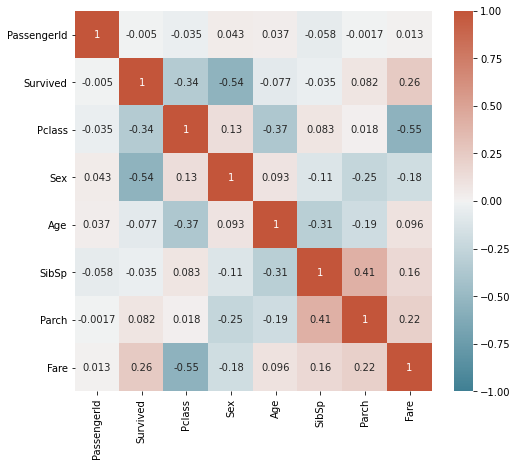

In [84]:
plt.figure(figsize=(8,7))
sns.heatmap(
    corr_data.corr(),
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(220, 20, as_cmap=True),
    annot=True)

- Survived feature is correlated with Sex, Pclass and Fare

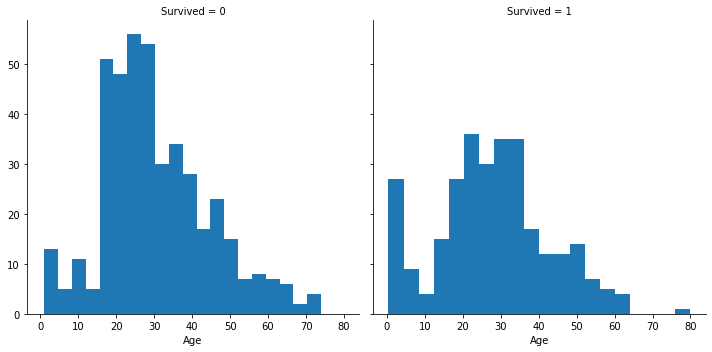

In [85]:
sns.FacetGrid(train_data, col='Survived', height=5).map(plt.hist, 'Age', bins=20)

- Many kids with age < 5 survived
- A lot of people between 15 to 30 did not survive

In [86]:
train_data['AgeBand'] = pd.cut(train_data['Age'], 5)
train_data[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.34, 16.336]",0.550000
1,"(16.336, 32.252]",0.369942
2,"(32.252, 48.168]",0.404255
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


### Processing data for training

In [87]:
# Converting columns to numerical data
def categorical_to_numerical(df):
    df['Sex'] = df['Sex'].map({'female': 0, 'male': 1})
    return df

In [88]:
# Dropping features
def drop_features(df, features):
    return df.drop(columns=features)

In [89]:
# Map name to new title feature with numerical values
def map_title_feature(df):
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt',\
                                       'Col', 'Don', 'Dr', 'Major',\
                                       'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms', 'Mme'], ['Miss', 'Miss', 'Mrs'])
    
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    df['Title'] = df['Title'].map(title_mapping)
    
    df = df.drop(columns=['Name'])
    return df

In [90]:
# Process NaN values
def process_nan_values(df):
    df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].transform(impute_median)
    df['Age'] = df['Age'].astype(int)
    
    h_freq = df['Embarked'].dropna().mode()[0]
    df['Embarked'] = df['Embarked'].fillna(h_freq)
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

    df['Fare'].fillna(df['Fare'].dropna().median(), inplace=True)
    
    return df

def impute_median(series):
    return series.fillna(series.median())

In [91]:
# Spliting into bands and converting to numerical values
def split_into_bands(df):
    df.loc[ df['Age'] <= 16, 'Age'] = 0
    df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age'] = 1
    df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age'] = 2
    df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age'] = 3
    df.loc[ df['Age'] > 64, 'Age']
    df['Age'] = df['Age'].astype(int)
    
    df.loc[ df['Fare'] <= 7.91, 'Fare'] = 0
    df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
    df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare']   = 2
    df.loc[ df['Fare'] > 31, 'Fare'] = 3
    df['Fare'] = df['Fare'].astype(int)
    
    return df

In [93]:
train_data = pd.read_csv("./datasets/train.csv")
test_data = pd.read_csv("./datasets/test.csv")

train_data = drop_features(train_data, ['Cabin', 'Ticket', 'Parch', 'SibSp'])
train_data = categorical_to_numerical(train_data)
train_data = map_title_feature(train_data)
train_data = process_nan_values(train_data)
train_data = split_into_bands(train_data)
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title
0,1,0,3,1,1,0,0,1
1,2,1,1,0,2,3,1,3
2,3,1,3,0,1,1,0,2
3,4,1,1,0,2,3,0,3
4,5,0,3,1,2,1,0,1
